In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import platform
from IPython.display import display, clear_output, HTML
from datetime import datetime
from PIL import Image

from time import sleep
from tqdm.auto import tqdm

import selenium
from selenium.webdriver.common.by import By
from selenium.webdriver import Firefox, ActionChains

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
selenium.__version__

'3.141.0'

## Parameters

In [3]:
SITE_ROOT = 'https://jdi-testing.github.io/jdi-light/'
DRIVER_FILE = 'geckodriver.exe'
LOGIN = 'Roman'
PASSWORD = 'Jdi1234'
SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False


In [4]:
if platform.system()=='Windows':
    
    if os.path.isfile(DRIVER_FILE):
        path = set(os.environ['PATH'].split(';'))
        path.add(os.getcwd())
        os.environ['PATH'] = ';'.join(path).strip(';')

In [5]:
print(os.environ['PATH'])

C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\PYTHON\envs\py37-torch\Library\bin;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\PYTHON\envs\py37-torch\Library\mingw-w64\bin;C:\PYTHON\condabin;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\PYTHON;C:\PYTHON\Scripts;C:\WINDOWS\system32;C:\Program Files\NVIDIA Corporation\Nsight Compute 2019.1;C:\PYTHON\Library\usr\bin;.;C:\PYTHON\Library\mingw-w64\bin;C:\PYTHON\envs\py37-torch\Scripts;C:\Program Files\Git\cmd;C:\WINDOWS\System32\OpenSSH;C:\cuda\bin;C:\PYTHON\envs\py37-torch\Library\usr\bin;C:\Program Files\Docker\Docker\resources\bin;C:\Users\Vyacheslav\AppData\Local\Microsoft\WindowsApps;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\libnvvp;C:\PYTHON\Library\bin;C:\PYTHON\envs\py37-torch;C:\Program Files\Microsoft VS Code\bin;C:\PYTHON\envs\py37-torch\bin;C:\ProgramData\DockerDesktop\version-bin;C:\Data-Science\jdi-qasp-ml


In [6]:
# os.environ['PATH']=os.environ['PATH']+f';{os.getcwd()}'

In [7]:
# os.environ['PATH']

## Create driver (HEADLESS={True|False})

In [8]:
options = selenium.webdriver.FirefoxOptions()
options.headless = HEADLESS

In [9]:
driver = Firefox(executable_path= os.path.join(os.getcwd(),'geckodriver.exe'), options=options)
driver.get(SITE_ROOT)

In [10]:
driver.get_window_position(), driver.get_window_size(), driver.title

({'x': 4, 'y': 4}, {'width': 1366, 'height': 768}, 'Home Page')

## Maximize window

In [11]:
# Maximize window
def maximize_window(driver=driver):
    S = lambda X: driver.execute_script('return document.body.parentNode.scroll' + X )
    driver.set_window_size(S('Width'), S('Height'))
    driver.find_element_by_tag_name('body')
    print('Window maximized')


## Take Screenshot

In [12]:
import io
import os

def screenshot(driver=driver, save_to_file:str=None, display:bool = False):
    """
        take a screenshot, returns numpy array
        and optionaly shows the screenshot 
    """

    os.makedirs('tmp', exist_ok=True)
    
    if save_to_file is None:
        fn = 'tmp/'+str(datetime.now())+".png"
        fn = fn.replace(':','_').replace(' ',"T")
    else:
        fn = save_to_file.strip('.png')+'.png'
    
    if not driver.save_screenshot(fn):
        print('cannot save screenshot')
    
    img = plt.imread(fn)
    if display:
        plt.imshow(img)
        
    return img

'Home Page'

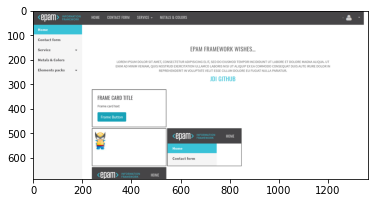

In [13]:
plt.imshow(screenshot(driver=driver))
driver.title

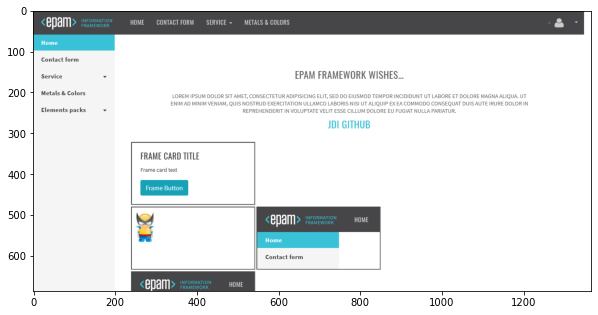

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(screenshot(driver))

In [15]:
maximize_window()

Window maximized


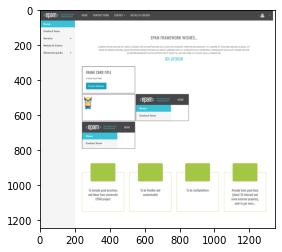

In [16]:
plt.imshow(screenshot(driver))

## Login

In [17]:
driver.find_element_by_id("user-icon").click()
driver.find_element_by_id("name").send_keys(LOGIN)
driver.find_element_by_id("password").send_keys(PASSWORD)
driver.find_element_by_id("login-button").click()
sleep(WAIT_TIME_SECONDS)

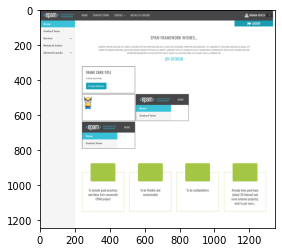

In [18]:
plt.imshow(screenshot(driver))

## Get element picture

In [19]:
import io

def get_pict(web_element):
    if web_element.is_displayed():
        print('displayed')
    else:
        print('hidden element')
        return None
        
    try:
        png = web_element.screenshot_as_png
    except:
        print('No png for element:', web_element)
        return None
    if png is None:
        return  None
    with io.BytesIO(png) as f:
        img = plt.imread(f)
    return img

**Test get_pict**

In [20]:
e = driver.find_elements_by_xpath('//button')[1]

displayed


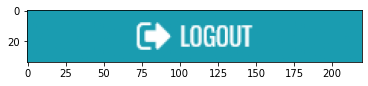

In [21]:
img = get_pict(e)
if img is not None:
    plt.imshow(img)

In [22]:
e = driver.find_elements_by_xpath('//a')[-1]

displayed


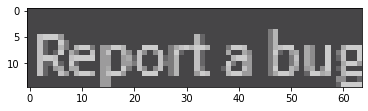

In [23]:
img = get_pict(e)
if img is not None:
    plt.imshow(img)

## Check HOVER event

In [24]:
MAX_PICT_SIZE_TRESHOLD = 228

def is_hover(e, driver):
    """
        Checks the element changes when mouse is hover
        
    """
    if not e.is_displayed():
        return (False, None, None)
    
    return_picts = True
    
    if max(e.size['width'], e.size['height']) > MAX_PICT_SIZE_TRESHOLD:
        return_picts = False
    
    ActionChains(driver)\
        .move_to_element(driver.find_element_by_xpath('//body'))\
        .perform()
    
    sleep(.2)
    
    try:
    
        _before = e.screenshot_as_base64

        # print(_before)
        hover = ActionChains(driver).move_to_element(e)
        hover.perform()

        sleep(.2)
        _after = e.screenshot_as_base64
        # print(_after)
        _hover = _after!=_before
        
        if return_picts == False: # Drop big picts
            _before = None
            _after = None

        return (_hover, _before, _after)        
    
    except:
        
        return (False, None, None)



## Get All elements, and their parents

In [25]:
from tqdm.auto import tqdm
from time import sleep

In [26]:
def get_all_elements(driver=driver):
    
    elements_all = driver.find_elements_by_xpath('//*')
    print(f'Number of discovered elements: {len(elements_all)}')
    # maximize_window(driver=driver)
    
    columns = [
        'parent_id',
        'element_id',
        'tag_name',
        'x',
        'y',
        'height',
        'width',
        'displayed',
        'enabled',
        'selected',
        'text',
        'is_hover',
        'b64_before_hover',
        'b64_after_hover'
    ]

    elements_a = []

    for e in tqdm(elements_all):
        
        txt = e.get_attribute('text')
        hover, hover_before, hover_after = is_hover(e=e, driver=driver)
        
        try:
            parents = e.find_elements_by_xpath('./..')
            if len(parents) > 1:
                raise('More then one parent for element:', e)
            parent_id = parents[0].id
        except:
            display(HTML(f'No parent for tag:<b>{e.tag_name}</b>'))
            display(e.id)
            parent_id = None
        
        elements_a.append([
            parent_id,
            e.id,
            e.tag_name,
            e.location['x'],
            e.location['y'],
            e.size['height'],
            e.size['width'],
            e.is_displayed(),
            e.is_enabled(),
            e.is_selected(),
            txt,
            hover,
            hover_before,
            hover_after
        ])

    e_df = pd.DataFrame(elements_a)
    e_df.columns = columns
    return e_df

In [27]:
%%time
elements_df = get_all_elements()
print(driver.title)
elements_df

Number of discovered elements: 228


  0%|          | 0/228 [00:00<?, ?it/s]

'fa72d101-a8be-472d-9966-9f53ffe1b51a'

Home Page
Wall time: 2min 2s


,parent_id,element_id,tag_name,x,y,height,width,displayed,enabled,selected,text,is_hover,b64_before_hover,b64_after_hover
0,None,fa72d101-a8be-472d-9966-9f53ffe1b51a,html,0,0,1245.0,1332.000000,True,True,False,None,False,None,None
1,fa72d101-a8be-472d-9966-9f53ffe1b51a,2ae39727-0c0e-4bd2-8a5b-bc80be9db558,head,0,0,0.0,0.000000,False,True,False,None,False,None,None
2,2ae39727-0c0e-4bd2-8a5b-bc80be9db558,9dc73143-c620-465a-8322-dd40b3afc908,meta,0,0,0.0,0.000000,False,True,False,None,False,None,None
3,2ae39727-0c0e-4bd2-8a5b-bc80be9db558,d517ed86-596c-4925-8a48-bc7c2589469a,title,0,0,0.0,0.000000,False,True,False,Home Page,False,None,None
4,2ae39727-0c0e-4bd2-8a5b-bc80be9db558,0a0dae74-2686-4a26-9d74-45999de8ec41,meta,0,0,0.0,0.000000,False,True,False,None,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,319f6645-e7d6-4a75-8355-520494f59a13,7d96f423-c043-4a98-9dfb-43cdd37ce12f,li,1230,1280,15.0,2.899994,True,True,False,None,False,iVBORw0KGgoAAAANSUhEUgAAAAIAAAAPCAYAAADOKB76AA...,iVBORw0KGgoAAAANSUhEUgAAAAIAAAAPCAYAAADOKB76AA...
224,319f6645-e7d6-4a75-8355-520494f59a13,a1801019-6de4-4847-a41c-1b4ab389a7e9,li,1248,1280,15.0,64.100006,True,True,False,None,True,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAPCAYAAABUZ8lnAA...,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAPCAYAAABUZ8lnAA...
225,a1801019-6de4-4847-a41c-1b4ab389a7e9,06d614a0-2822-40a2-8d65-505b95ce7b60,a,1248,1280,15.0,64.100006,True,True,False,Report a bug,True,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAPCAYAAABUZ8lnAA...,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAPCAYAAABUZ8lnAA...
226,18bc12a3-a916-4fed-ace4-520d2d6315b4,ec729250-a835-481f-967f-2656f4875e17,script,0,50,0.0,0.000000,False,True,False,"\n UUI.Vertical_Menu.init({""open"": true...",False,None,None


In [28]:
driver.find_element(By.LINK_TEXT, "Elements packs").click()
sleep(1)
driver.find_element(By.LINK_TEXT, "HTML 5").click()
sleep(WAIT_TIME_SECONDS)

In [29]:
os.makedirs('dataset', exist_ok=True)

In [30]:
maximize_window()
screen_img = screenshot(driver=driver, save_to_file='dataset/screenshot-01.png')


Window maximized


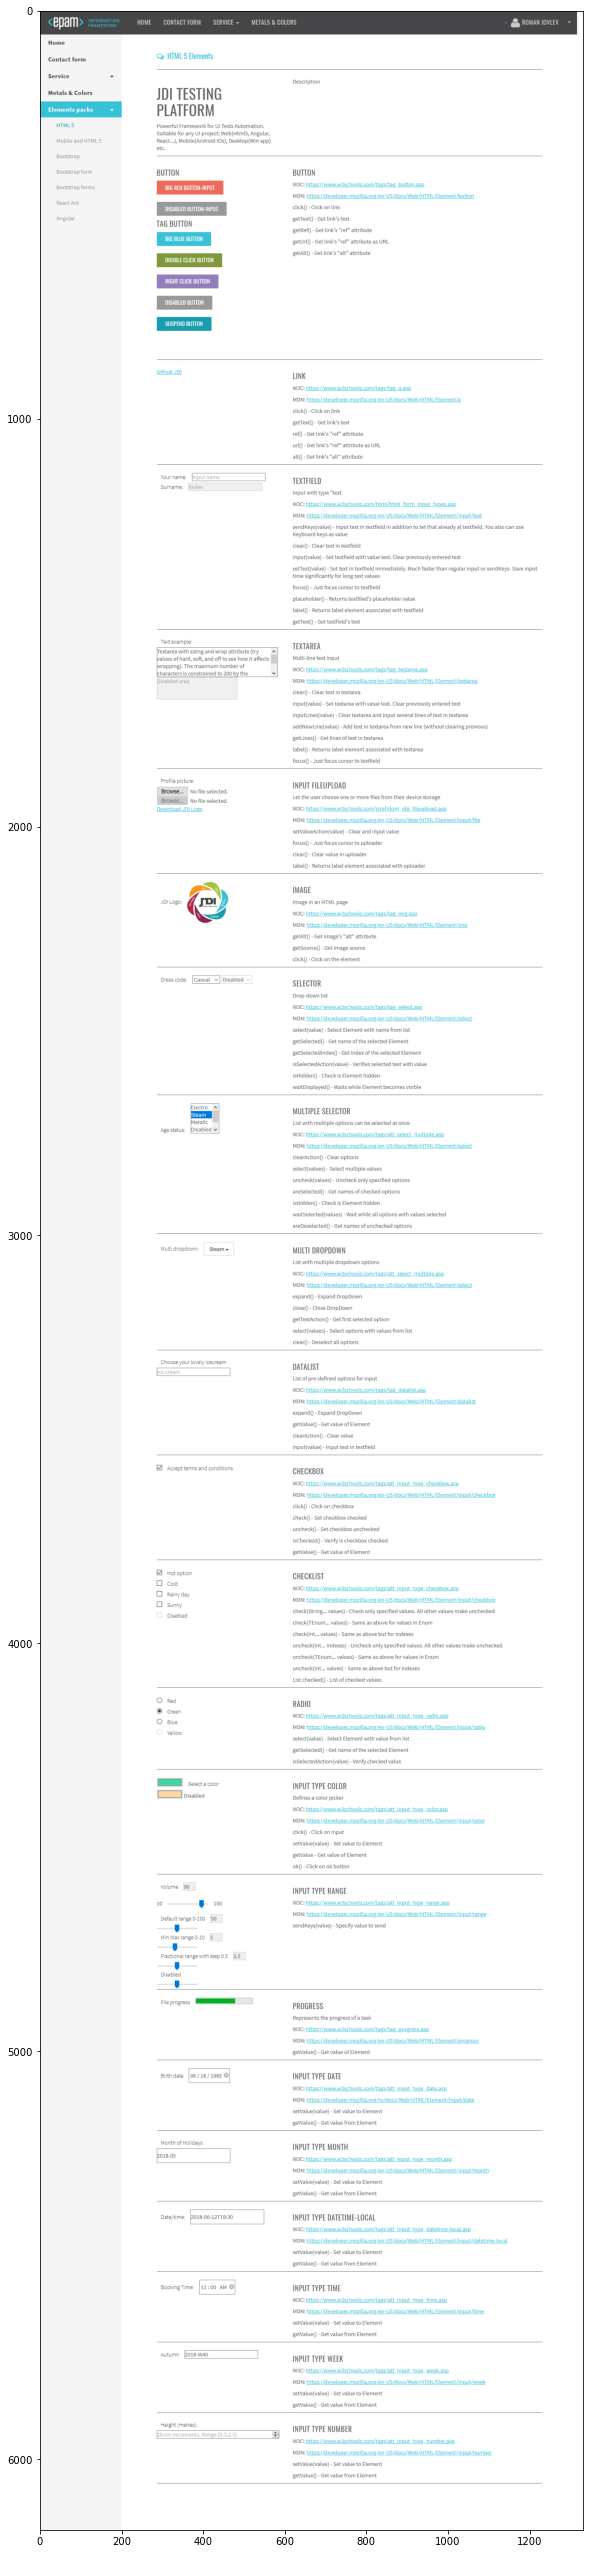

In [40]:
SCR_WIDTH = 10 # inches
SCR_HEIGHT = SCR_WIDTH/screen_img.shape[1]*screen_img.shape[0]
SCR_WIDTH, SCR_HEIGHT
plt.figure(figsize=(SCR_WIDTH, SCR_HEIGHT))
plt.imshow(screen_img);
# plt.imshow(screen_img[:,:,1], cmap='gray', vmin = 0, vmax = 255,interpolation='none')

In [41]:
screen_img.shape

(6173, 1332, 4)

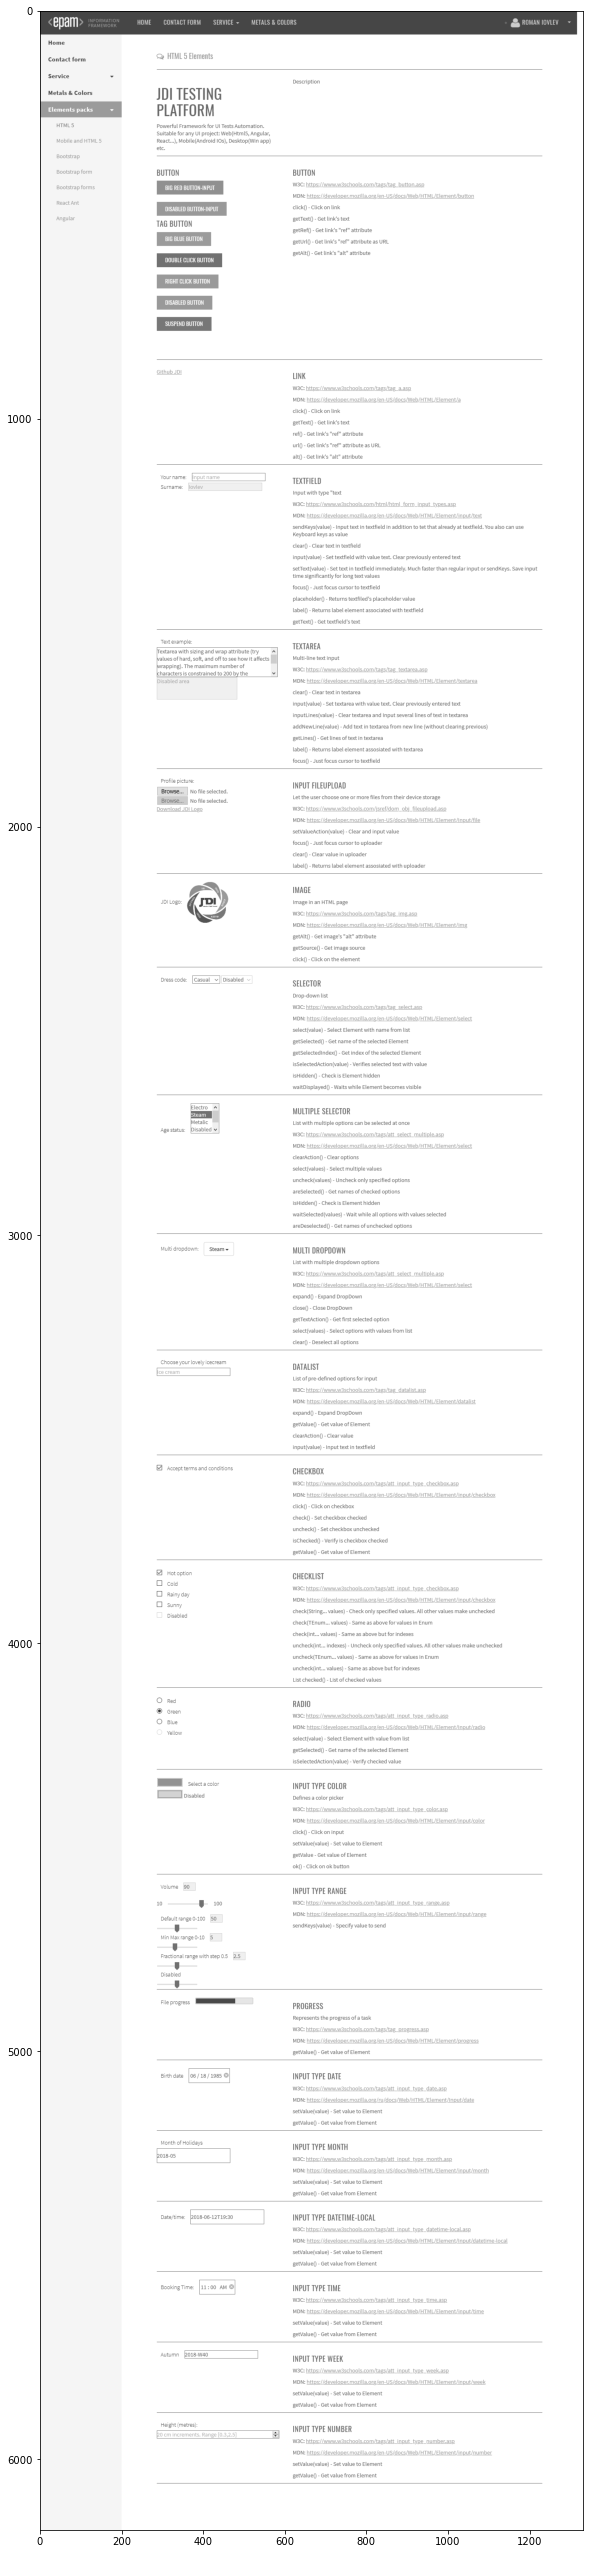

In [55]:
plt.figure(figsize=(SCR_WIDTH, SCR_HEIGHT))
plt.imshow((screen_img[:,:,0]+screen_img[:,:,1]+screen_img[:,:,2])/765.0,cmap='gray')

In [32]:
%%time
elements_df = get_all_elements()
print('title:', driver.title)
elements_df

Number of discovered elements: 662


  0%|          | 0/662 [00:00<?, ?it/s]

'678a2cd8-9b5a-4b57-93ae-5d176292f95d'

title: HTML 5
Wall time: 9min 13s


,parent_id,element_id,tag_name,x,y,height,width,displayed,enabled,selected,text,is_hover,b64_before_hover,b64_after_hover
0,None,678a2cd8-9b5a-4b57-93ae-5d176292f95d,html,0,0,6173.0,1315.0,True,True,False,None,True,None,None
1,678a2cd8-9b5a-4b57-93ae-5d176292f95d,4181614c-db88-4854-a1ea-90de3d30fc42,head,0,0,0.0,0.0,False,True,False,None,False,None,None
2,4181614c-db88-4854-a1ea-90de3d30fc42,e719bdec-f5ba-4444-b8b3-df6cdc1faf2e,meta,0,0,0.0,0.0,False,True,False,None,False,None,None
3,4181614c-db88-4854-a1ea-90de3d30fc42,59239acd-8de9-4a23-afa3-dbc29202d940,title,0,0,0.0,0.0,False,True,False,HTML 5,False,None,None
4,4181614c-db88-4854-a1ea-90de3d30fc42,633bda8c-aa69-4c78-8509-6f6393884f54,meta,0,0,0.0,0.0,False,True,False,None,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,7e5f2ddf-395c-4bbf-9101-6165259d8e17,6696257c-29a3-40ae-805e-6028bfd5a96b,script,0,50,0.0,0.0,False,True,False,\n function show_val(element) {\n\t\tconst ...,False,None,None
658,7e5f2ddf-395c-4bbf-9101-6165259d8e17,5d4503c3-ce09-4b70-8f64-361ded83806e,script,0,50,0.0,0.0,False,True,False,\n $('#multi-dropdown').multiselect();\n,False,None,None
659,7e5f2ddf-395c-4bbf-9101-6165259d8e17,261778b1-d859-4c90-90bf-f5a844174f3c,script,0,50,0.0,0.0,False,True,False,"\n UUI.Vertical_Menu.init({""open"":true});\n",False,None,None
660,7e5f2ddf-395c-4bbf-9101-6165259d8e17,2ecbc7f1-6567-4a34-985e-c8494da847da,script,0,50,0.0,0.0,False,True,False,\n $('.selectpicker').selectpicker();\n,False,None,None


**Find all children**

In [33]:
# def get_level(e, parents_list=[]): # number of parents
    

In [34]:
# from tqdm.auto import trange
# with trange(0, elements_df.shape[0] ) as bar:
#     for i, r in elements_df.iterrows():
#         print(r.element_id)
#         bar.update(1)
    

In [35]:
#elements_df.shape[0]

In [36]:
#e.rect

In [39]:
plt.imshow?

## Classes

In [ ]:
[
    "textfield",
    "dropdown",
    "checkbox",
    "textarea",
    "button",
    "label",
    "text",
    "link",
    "fileinput",
    "image",
    "colorpicker",
    "range",
    "progressbar",
    "datetimeselector",
    "numberselector",
    "dropdownselector",
    "checklist",
    "radiobutton",
    "table"
]